In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from pytorch_forecasting.data import TimeSeriesDataSet
from pytorch_forecasting.optim import Optimizer
from pytorch_forecasting.models import DeepAR
from pytorch_forecasting.data.encoders import NaNLabelEncoder
from pytorch_forecasting.metrics import SMAPE,RMSE

In [3]:
use_col = ['volumn','datetime']
data = pd.read_csv('../traffic/data/5.csv',usecols=use_col)
# data.rename({'service_name':'group_ids','datetime':'b','volumn':'value','packets':'c','unknown':'d'},axis=1,inplace=True)
# data.drop(columns=['b','c','d'],inplace=True)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['group_ids']=np.tile('0',len(data))
data['time_idx']=np.arange(len(data))
data['value'] = data['value'] * 8 / 1000000
data['datetime'] = pd.to_datetime(data['datetime'])
data["day_of_week"] = data.datetime.dt.dayofweek.astype(str).astype("category")
data["week_of_year"] = data.datetime.dt.weekofyear.astype(str).astype("category")  # categories have be strings
data["month"] = data.datetime.dt.month.astype(str).astype("category")  # categories have be strings
data['time'] = np.tile(np.arange(1440),27) #1일이 1440으로 돼있으므로
data['time'] = data['time'].astype(str).astype("category") # numpy에 astype적용시 적용이 안된다
data

/tmp/ipykernel_416494/1451637192.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data["week_of_year"] = data.datetime.dt.weekofyear.astype(str).astype("category")  # categories have be strings


,datetime,value,group_ids,time_idx,day_of_week,week_of_year,month,time
0,2018-07-25 00:00:00,0.739264,0,0,2,30,7,0
1,2018-07-25 00:01:00,0.737200,0,1,2,30,7,1
2,2018-07-25 00:02:00,0.759168,0,2,2,30,7,2
3,2018-07-25 00:03:00,0.741552,0,3,2,30,7,3
4,2018-07-25 00:04:00,0.749392,0,4,2,30,7,4
...,...,...,...,...,...,...,...,...
38875,2018-08-20 23:55:00,0.652168,0,38875,0,34,8,1435
38876,2018-08-20 23:56:00,0.664736,0,38876,0,34,8,1436
38877,2018-08-20 23:57:00,0.678984,0,38877,0,34,8,1437
38878,2018-08-20 23:58:00,0.653888,0,38878,0,34,8,1438


<AxesSubplot: >

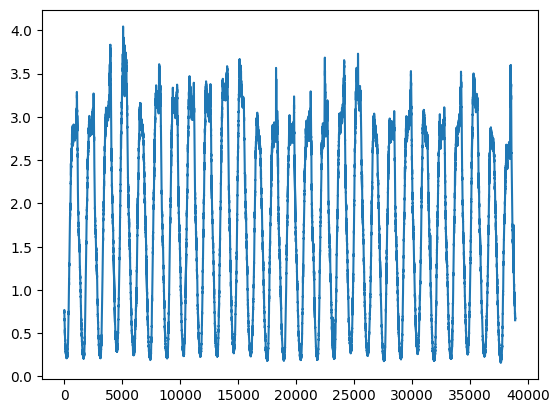

In [4]:
data['value'].plot()

In [5]:
Train_data = data.iloc[:28800]
Test_data = data.iloc[28800:]

In [6]:
encoder_length =1440
prediction_length=10080 # encoding 기간은 1일 prediction 기간은 7일

In [7]:
training = TimeSeriesDataSet(
    data=Train_data,
    max_encoder_length = encoder_length,
    min_encoder_length=1,
    max_prediction_length = prediction_length,
    min_prediction_length=1,
    target = 'value',
    group_ids = ['group_ids'],
    time_idx = 'time_idx',
    time_varying_known_categoricals=["week_of_year", "day_of_week","month","time"],
    time_varying_unknown_reals = ['value'],
    time_varying_known_reals = ['time_idx'],
    add_relative_time_idx = True,  # add as feature
    add_target_scales = True,  # add as feature
    add_encoder_length = True,  # add as feature
    categorical_encoders={
        'week_of_year':NaNLabelEncoder(add_nan=True),
        'day_of_week':NaNLabelEncoder(add_nan=True),
        'month':NaNLabelEncoder(add_nan=True),
        'time':NaNLabelEncoder(add_nan=True)
    }
# NaNLableEncoder(add_nan=True)를 쓰지 않으면 새로운 categorical 변수에 대처 불가능
# https://stackoverflow.com/questions/74621525/temporal-fusion-transformer
# https://stackoverflow.com/questions/71098518/unknown-category-2-encountered-set-add-nan-true-to-allow-unknown-categories
)

In [8]:
batch_size = 64
train_dataloader = training.to_dataloader(train=False, batch_size = batch_size,num_workers = 0)

In [9]:
from pytorch_lightning.callbacks import LearningRateFinder,EarlyStopping
import pytorch_lightning as pl
early_stopping = EarlyStopping(monitor = 'train_loss', min_delta = 1e-2,
                               patience = 5, verbose = True, mode = "min")
lr_find = LearningRateFinder(min_lr = 1e-10,
                            max_lr = 1,early_stop_threshold=10)
trainer = pl.Trainer(
    gpus=[0],
    gradient_clip_val=0.1,
    max_epochs=30,
    callbacks=[early_stopping,lr_find]
)

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [10]:
net = DeepAR.from_dataset(training,
                         rnn_layers = 2,
                         hidden_size = 16,
                         optimizer = 'adam',
                         )

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [11]:
import torch

DEVICE = torch.device("cuda:0")

net.to(DEVICE)

DeepAR(
  	"categorical_groups":                {}
  	"cell_type":                         LSTM
  	"dropout":                           0.1
  	"embedding_labels":                  {'week_of_year': {'nan': 0, '30': 1, '31': 2, '32': 3, '33': 4}, 'day_of_week': {'nan': 0, '0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7}, 'month': {'nan': 0, '7': 1, '8': 2}, 'time': {'nan': 0, '0': 1, '1': 2, '10': 3, '100': 4, '1000': 5, '1001': 6, '1002': 7, '1003': 8, '1004': 9, '1005': 10, '1006': 11, '1007': 12, '1008': 13, '1009': 14, '101': 15, '1010': 16, '1011': 17, '1012': 18, '1013': 19, '1014': 20, '1015': 21, '1016': 22, '1017': 23, '1018': 24, '1019': 25, '102': 26, '1020': 27, '1021': 28, '1022': 29, '1023': 30, '1024': 31, '1025': 32, '1026': 33, '1027': 34, '1028': 35, '1029': 36, '103': 37, '1030': 38, '1031': 39, '1032': 40, '1033': 41, '1034': 42, '1035': 43, '1036': 44, '1037': 45, '1038': 46, '1039': 47, '104': 48, '1040': 49, '1041': 50, '1042': 51, '1043': 52, '1044': 53, '1

In [12]:
model=trainer.fit(net,train_dataloaders=train_dataloader)

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Finding best initial lr: 100%|██████████| 100/100 [01:03<00:00,  1.57it/s]
Restoring states from the checkpoint path at /hdd_1/sjlee/Paper_Project/.lr_find_260dc8e9-2de4-4e5d-9c2b-4a8dbe0a9861.ckpt
Restored all states from the checkpoint file at /hdd_1/sjlee/Paper_Project/.lr_find_260dc8e9-2de4-4e5d-9c2b-4a8dbe0a9861.ckpt

  |

Epoch 0: 100%|██████████| 630/630 [04:03<00:00,  2.59it/s, loss=-1.49, v_num=73, train_loss_step=-1.57, train_loss_epoch=2.940]  

Metric train_loss improved. New best score: -0.732


Epoch 1:   0%|          | 0/630 [00:00<?, ?it/s, loss=-1.49, v_num=73, train_loss_step=-1.57, train_loss_epoch=-.732]          

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:447: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(


Epoch 1: 100%|██████████| 630/630 [03:19<00:00,  3.15it/s, loss=-1.86, v_num=73, train_loss_step=-1.85, train_loss_epoch=-.732]  

Metric train_loss improved by 0.878 >= min_delta = 0.01. New best score: -1.609


Epoch 2: 100%|██████████| 630/630 [03:31<00:00,  2.99it/s, loss=-1.93, v_num=73, train_loss_step=-1.96, train_loss_epoch=-1.61]  

Metric train_loss improved by 0.157 >= min_delta = 0.01. New best score: -1.767


Epoch 3: 100%|██████████| 630/630 [03:20<00:00,  3.14it/s, loss=-2.13, v_num=73, train_loss_step=-2.14, train_loss_epoch=-1.77]  

Metric train_loss improved by 0.166 >= min_delta = 0.01. New best score: -1.933


Epoch 4: 100%|██████████| 630/630 [03:19<00:00,  3.15it/s, loss=-2.09, v_num=73, train_loss_step=-2.13, train_loss_epoch=-1.93] 

Metric train_loss improved by 0.064 >= min_delta = 0.01. New best score: -1.997


Epoch 5: 100%|██████████| 630/630 [03:19<00:00,  3.15it/s, loss=-2.11, v_num=73, train_loss_step=-2.13, train_loss_epoch=-2.00]  

Metric train_loss improved by 0.026 >= min_delta = 0.01. New best score: -2.022


Epoch 7: 100%|██████████| 630/630 [03:20<00:00,  3.14it/s, loss=-2.23, v_num=73, train_loss_step=-2.14, train_loss_epoch=-2.02]   

Metric train_loss improved by 0.055 >= min_delta = 0.01. New best score: -2.077


Epoch 8: 100%|██████████| 630/630 [03:26<00:00,  3.06it/s, loss=-2.24, v_num=73, train_loss_step=-2.23, train_loss_epoch=-2.08] 

Metric train_loss improved by 0.122 >= min_delta = 0.01. New best score: -2.199


Epoch 9: 100%|██████████| 630/630 [03:22<00:00,  3.11it/s, loss=-2.14, v_num=73, train_loss_step=-2.22, train_loss_epoch=-2.20] 

Metric train_loss improved by 0.049 >= min_delta = 0.01. New best score: -2.249


Epoch 12: 100%|██████████| 630/630 [03:23<00:00,  3.10it/s, loss=-2.31, v_num=73, train_loss_step=-2.34, train_loss_epoch=-2.25]   

Metric train_loss improved by 0.033 >= min_delta = 0.01. New best score: -2.281


Epoch 13: 100%|██████████| 630/630 [04:25<00:00,  2.37it/s, loss=-2.33, v_num=73, train_loss_step=-2.35, train_loss_epoch=-2.28] 

Metric train_loss improved by 0.037 >= min_delta = 0.01. New best score: -2.318


Epoch 15: 100%|██████████| 630/630 [04:31<00:00,  2.32it/s, loss=-2.41, v_num=73, train_loss_step=-2.40, train_loss_epoch=-2.31]

Metric train_loss improved by 0.026 >= min_delta = 0.01. New best score: -2.344


Epoch 17: 100%|██████████| 630/630 [03:21<00:00,  3.13it/s, loss=-2.39, v_num=73, train_loss_step=-2.43, train_loss_epoch=-2.35] 

Metric train_loss improved by 0.046 >= min_delta = 0.01. New best score: -2.390


Epoch 22: 100%|██████████| 630/630 [03:23<00:00,  3.10it/s, loss=-2.48, v_num=73, train_loss_step=-2.47, train_loss_epoch=-2.37]  

Metric train_loss improved by 0.031 >= min_delta = 0.01. New best score: -2.421


Epoch 23: 100%|██████████| 630/630 [03:22<00:00,  3.11it/s, loss=-2.46, v_num=73, train_loss_step=-2.48, train_loss_epoch=-2.42]

Metric train_loss improved by 0.040 >= min_delta = 0.01. New best score: -2.462


Epoch 24: 100%|██████████| 630/630 [03:21<00:00,  3.12it/s, loss=-2.46, v_num=73, train_loss_step=-2.41, train_loss_epoch=-2.46]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: -2.477


Epoch 27: 100%|██████████| 630/630 [04:03<00:00,  2.58it/s, loss=-2.51, v_num=73, train_loss_step=-2.37, train_loss_epoch=-2.48]

Metric train_loss improved by 0.022 >= min_delta = 0.01. New best score: -2.499


Epoch 28: 100%|██████████| 630/630 [04:26<00:00,  2.36it/s, loss=-2.53, v_num=73, train_loss_step=-2.52, train_loss_epoch=-2.50]

Metric train_loss improved by 0.023 >= min_delta = 0.01. New best score: -2.522


Epoch 29: 100%|██████████| 630/630 [03:21<00:00,  3.13it/s, loss=-2.5, v_num=73, train_loss_step=-2.51, train_loss_epoch=-2.52] 

Metric train_loss improved by 0.012 >= min_delta = 0.01. New best score: -2.535


Epoch 29: 100%|██████████| 630/630 [03:21<00:00,  3.13it/s, loss=-2.5, v_num=73, train_loss_step=-2.51, train_loss_epoch=-2.53]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 630/630 [03:21<00:00,  3.13it/s, loss=-2.5, v_num=73, train_loss_step=-2.51, train_loss_epoch=-2.53]


In [13]:
best_model_path = trainer.checkpoint_callback.best_model_path

In [14]:
best_model = DeepAR.load_from_checkpoint(best_model_path)

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [15]:
new_encoder_data = Train_data.iloc[-encoder_length:]
new_decoder_data = Test_data.copy()
new_decoder_data['value'] = np.tile(new_encoder_data['value'].iloc[-1],len(new_decoder_data))
new_decoder_data

,datetime,value,group_ids,time_idx,day_of_week,week_of_year,month,time
28800,2018-08-14 00:00:00,0.68624,0,28800,1,33,8,0
28801,2018-08-14 00:01:00,0.68624,0,28801,1,33,8,1
28802,2018-08-14 00:02:00,0.68624,0,28802,1,33,8,2
28803,2018-08-14 00:03:00,0.68624,0,28803,1,33,8,3
28804,2018-08-14 00:04:00,0.68624,0,28804,1,33,8,4
...,...,...,...,...,...,...,...,...
38875,2018-08-20 23:55:00,0.68624,0,38875,0,34,8,1435
38876,2018-08-20 23:56:00,0.68624,0,38876,0,34,8,1436
38877,2018-08-20 23:57:00,0.68624,0,38877,0,34,8,1437
38878,2018-08-20 23:58:00,0.68624,0,38878,0,34,8,1438


In [16]:
new_prediction_data = pd.concat([new_encoder_data,new_decoder_data],ignore_index=True,axis=0)
new_raw_pred=best_model.predict(new_prediction_data , mode='prediction',return_x=False)

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:317: UserWarning: Found 1 unknown classes which were set to NaN
  warnings.warn(


In [17]:
new_raw_pred

tensor([[0.7020, 0.6891, 0.6859,  ..., 0.7158, 0.7212, 0.7123]])

In [18]:
pred = np.array(new_raw_pred.view(-1))

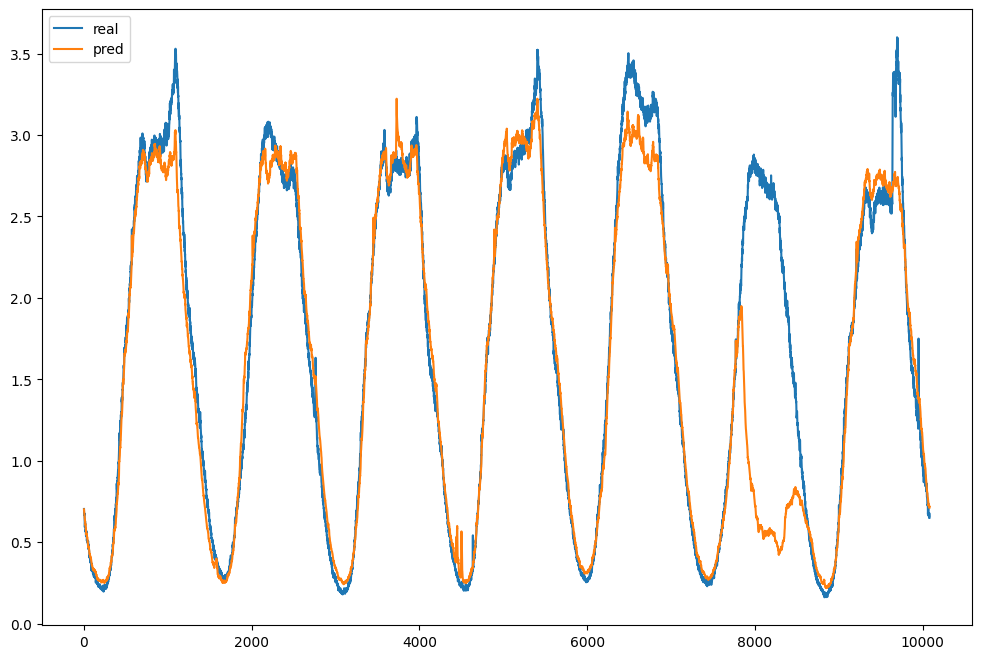

In [19]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),Test_data['value'],label='real')
axes.plot(np.arange(1,10081),pred,label='pred')
plt.legend()

In [20]:
pred

array([0.7019936 , 0.6891344 , 0.6859081 , ..., 0.71582013, 0.7211874 ,
       0.712323  ], dtype=float32)

In [21]:
actuals= torch.FloatTensor(Test_data['value'].values).view(1,-1)
actuals

tensor([[0.7041, 0.6899, 0.6666,  ..., 0.6790, 0.6539, 0.6499]])

In [22]:
print('smape',SMAPE()(new_raw_pred,actuals).item()*100,'%')
print('rmse',RMSE()(new_raw_pred,actuals).item())

smape 15.12969434261322 %
rmse 0.4768690764904022


https://pycj92.tistory.com/25<br>
https://pytorch-forecasting.readthedocs.io/en/stable/tutorials/deepar.html